# This code shows how to perform the preprocessing

In [1]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt  
import SimpleITK as itk

import functions.functions as fc
import functions.nifti_functions as nfc
import project_images_loader as pil

from scipy.ndimage import gaussian_filter
from scipy.signal import medfilt



### Visualization functions

In [3]:
def prob_color_atlas(labels_prob, layer):  
    color_prob_atlas = np.zeros((*labels_prob[0].shape[:2],3))
    color_prob_atlas[:,:,0] = labels_prob[0][...,layer]
    color_prob_atlas[:,:,1] = labels_prob[1][...,layer]
    color_prob_atlas[:,:,2] = labels_prob[2][...,layer]
    return color_prob_atlas

def get_best_layer(_mask):
    sumas_por_plano = np.sum(_mask, axis=(0, 1))
    return np.argmax(sumas_por_plano) 


### Label segmentation
performed with SPM

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


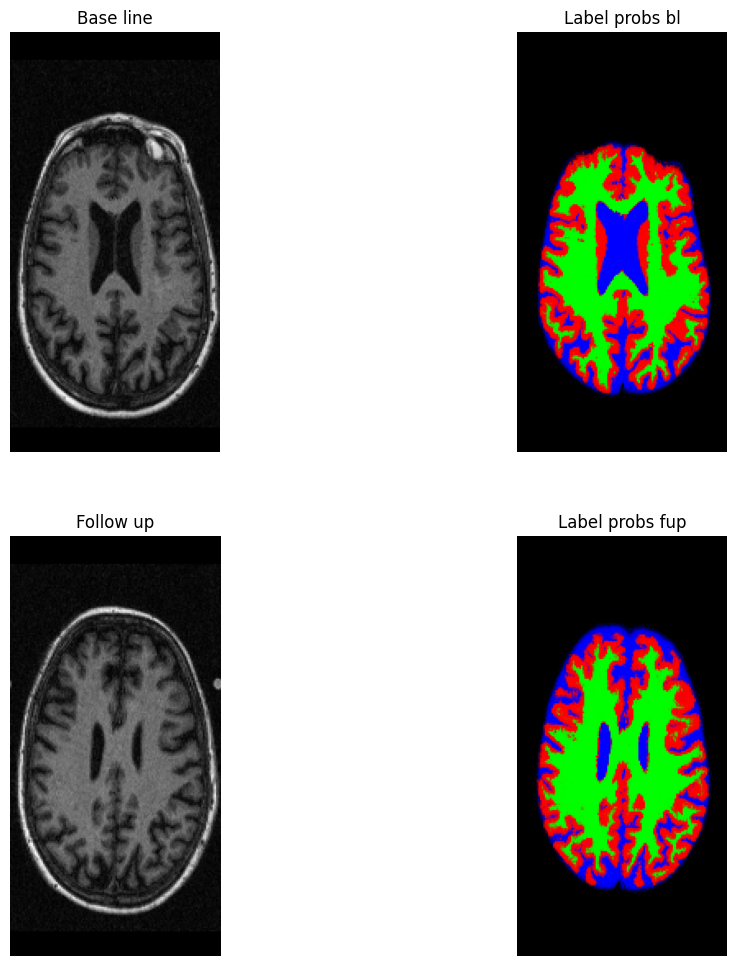

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


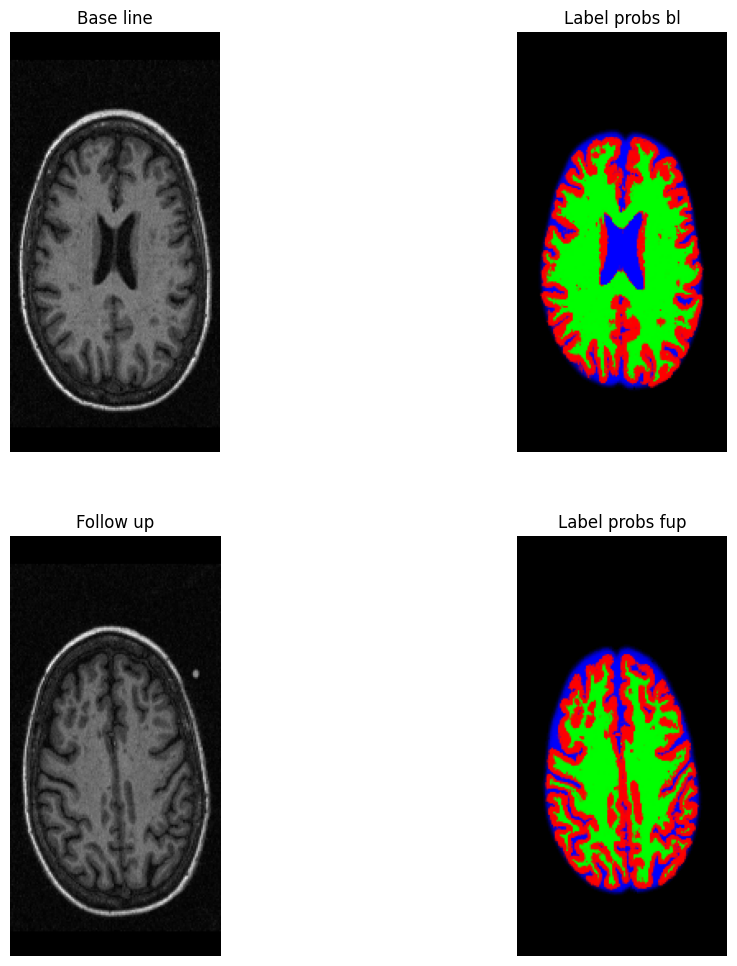

In [115]:
def show_segmentations():
    for patient_id in pil.IMG_NUMBERS_TRAIN[:2]:
        img_baseline, _ = pil.load_original_volume(patient_id, 1)
        img_gm_prob_label1, img_wm_prob_label1, img_csf_prob_label1 = pil.load_spm_labels(patient_id, 1, pil.FOLDER_RAW, -1)

        img_fup, _ = pil.load_original_volume(patient_id, 2)
        img_gm_prob_label2, img_wm_prob_label2, img_csf_prob_label2 = pil.load_spm_labels(patient_id, 2, pil.FOLDER_RAW, -1)

        fig, axs = plt.subplots(2,2, figsize=(12, 12))
        _layer1 = 150
        _layer2 = 150

        color_atlas_1 = prob_color_atlas([np.transpose(img_gm_prob_label1, (0, 2, 1)), np.transpose(img_wm_prob_label1, (0, 2, 1)), np.transpose(img_csf_prob_label1, (0, 2, 1))], _layer1)
        color_atlas_2 = prob_color_atlas([np.transpose(img_gm_prob_label2, (0, 2, 1)), np.transpose(img_wm_prob_label2, (0, 2, 1)), np.transpose(img_csf_prob_label2, (0, 2, 1))], _layer2)

        fc.imgshow_matplotlib("Base line",  np.flipud(np.transpose(img_baseline, (0, 2, 1))[..., _layer1]), subplot=axs[0][0])
        fc.imgshow_matplotlib("Label probs bl",  np.flipud(color_atlas_1), subplot=axs[0][1])
        fc.imgshow_matplotlib("Follow up",  np.flipud(np.transpose(img_fup, (0, 2, 1))[..., _layer2]), subplot=axs[1][0])
        fc.imgshow_matplotlib("Label probs fup",  np.flipud(color_atlas_2), subplot=axs[1][1])

        plt.show()
show_segmentations()

### Skull stripping

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


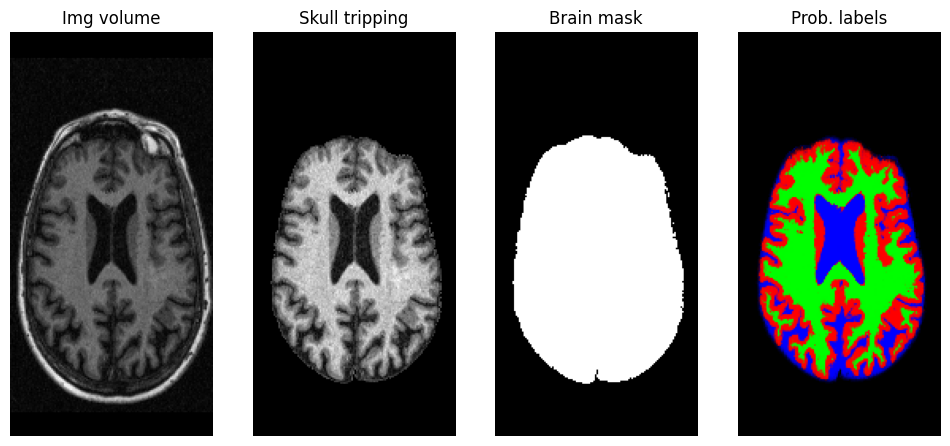

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


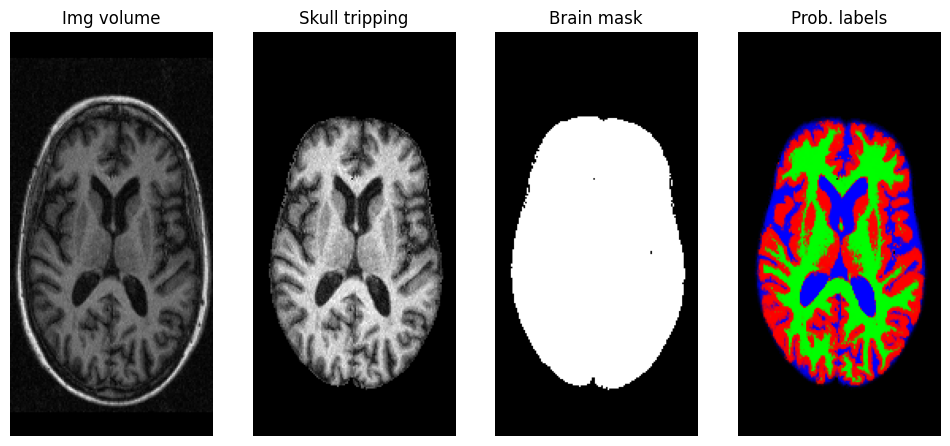

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


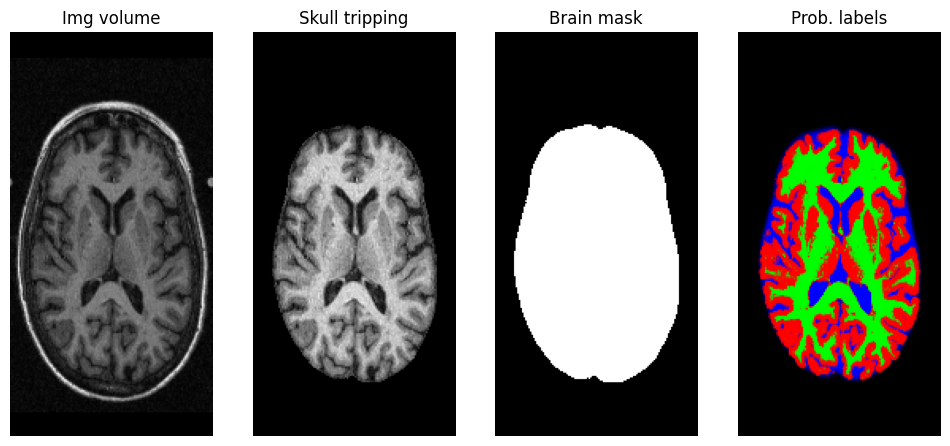

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


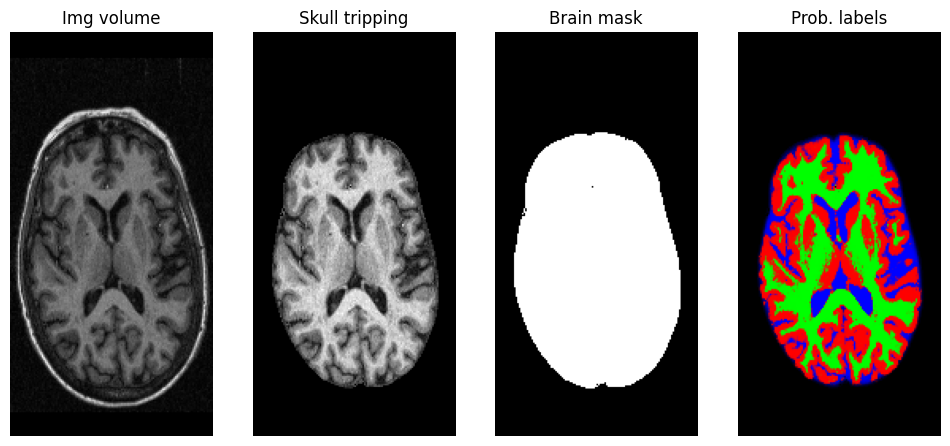

In [45]:
def perform_train_skull_stripping(visualize=False, save=False, save_brain_mask=False):
    for patient_id in pil.IMG_NUMBERS_TRAIN[:2]:
        for time in [1,2]:

            img, affine = pil.load_original_volume(patient_id, time)
            img_gm_prob_label, img_wm_prob_label, img_csf_prob_label = pil.load_spm_labels(patient_id, time, pil.FOLDER_RAW, -1)

            img_brain_mask = (img_gm_prob_label + img_wm_prob_label + img_csf_prob_label) > 0

            img_no_skull = img.copy()
            img_no_skull[~img_brain_mask] = 0

            if save:
                pil.save_volume(img_no_skull, affine, pil.NAME_NSK_VOLUME, patient_id, longitudinal=time, sub_folder=pil.FOLDER_RAW)

            if save_brain_mask:
                pil.save_volume(img_brain_mask.astype(np.uint8), affine, pil.NAME_NSK_VOLUME, patient_id, longitudinal=time, sub_folder=pil.FOLDER_RAW)

            if visualize:
                _layer = get_best_layer(np.transpose(img_brain_mask, (0, 2, 1)))
                # _layer = 90
                img_color_label = prob_color_atlas([np.transpose(img_gm_prob_label, (0, 2, 1)), 
                                                    np.transpose(img_wm_prob_label, (0, 2, 1)), 
                                                    np.transpose(img_csf_prob_label, (0, 2, 1))], _layer)

                fig, axs = plt.subplots(1,4, figsize=(12, 10))
                fc.imgshow_matplotlib("Img volume", np.flipud(np.transpose(img, (0, 2, 1))[..., _layer]), subplot=axs[0])
                fc.imgshow_matplotlib("Skull tripping", np.flipud(np.transpose(img_no_skull, (0, 2, 1))[..., _layer]), subplot=axs[1])
                fc.imgshow_matplotlib("Brain mask", np.flipud(np.transpose(img_brain_mask, (0, 2, 1))[..., _layer]), subplot=axs[2])
                fc.imgshow_matplotlib("Prob. labels", np.flipud(img_color_label), subplot=axs[3])
                plt.show()

perform_train_skull_stripping(visualize=True, save=False, save_brain_mask=False)

### Histogram matching

#### Parameters

In [50]:
# histograms
hist_range=(0,1)
num_bins=1000

# smoothing
filter_type = "gaussian" 
sigma = 20

# normalization
hist_normalization = "prob"



In [51]:
def normalize_image(img_original, mask=None, percentils=None):
    # If specific percentiles are provided, use them for normalization
    if percentils is not None:
        # Calculate the minimum and maximum value within the masked region of the image
        if mask is not None:
            min_value = np.percentile(img_original[mask>0], percentils[0])
            max_value = np.percentile(img_original[mask>0], percentils[1])
        else:
            min_value = np.percentile(img_original, percentils[0])
            max_value = np.percentile(img_original, percentils[1])
        # Normalize the image using the calculated min and max values
        img_original = (img_original - min_value) / (max_value - min_value)
        # Clip values below 0 to 0 and above 1 to 1
        img_original[img_original<0] = 0
        img_original[img_original>1] = 1
    # If no percentiles are provided, normalize by the maximum value within the mask
    else:
        if mask is not None:
            img_original /= np.max(img_original[mask>0])
        else:
            img_original /= np.max(img_original)
    return img_original


def histogram_smooth(hist, filter_type, sigma=3, kernel_size=3):
    # Apply Gaussian smoothing to the histogram if specified
    if filter_type == "gaussian":
        return gaussian_filter(hist, sigma=sigma)
    # Apply median filtering to the histogram if specified
    elif filter_type == "median":
        return medfilt(hist, kernel_size)


def _match_cumulative_cdf_hist(img, hist, bins, mask=None, normalization="prob", smoothing_type="gaussian", sigma=4):
    # Apply a mask if provided
    if mask is not None:
        # Calculate histogram of the masked image
        img_hist, _ = np.histogram(img.ravel()[mask.ravel() > 0], bins=bins)
        # Apply smoothing to the histogram
        img_hist = histogram_smooth(img_hist, filter_type=smoothing_type, sigma=sigma)
        # Normalize the histogram
        img_hist = fc.normalize_hist(img_hist, norm=normalization)
    # If no mask, process the whole image
    else:
        img_hist, _ = np.histogram(img.ravel(), bins=bins)
        img_hist = histogram_smooth(img_hist, filter_type=smoothing_type, sigma=sigma)
        img_hist = fc.normalize_hist(img_hist, norm=normalization)

    # Calculate the cumulative distribution function (CDF) of the image histogram
    src_quantiles = np.cumsum(img_hist)

    # Calculate the mid-values of each histogram bin
    tmpl_values = (bins[:-1] + bins[1:]) / 2
    # Calculate the CDF of the target histogram
    tmpl_quantiles = np.cumsum(hist) 

    # Interpolate the values based on the CDFs
    interp_values = np.interp(src_quantiles, tmpl_quantiles, tmpl_values)

    # Map the original image values to the new values based on the interpolated mapping
    img_mapped = interp_values[np.digitize(img.ravel(), bins[:-1], right=False) - 1]
    
    # Return the image reshaped to its original dimensions
    return img_mapped.reshape(img.shape)


#### Template hist

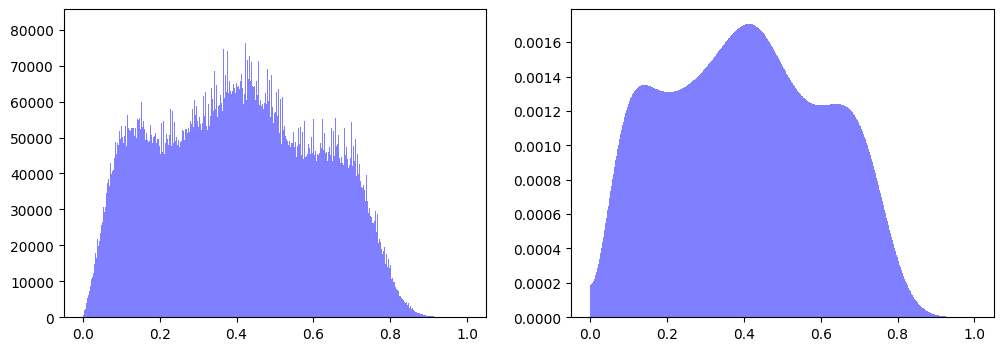

In [52]:
# compute template hist
def compute_template_hist(hist_range=(0,1), um_bins=1000):
    hist = None
    bins = None
    # Iterating over a predefined list of image numbers (IMG_NUMBERS_TRAIN)
    for patient_id in pil.IMG_NUMBERS_TRAIN:
        # Looping through two time points for each image number
        for time in [1,2]:
            img, _ = pil.load_nsk_volume(patient_id, time, sub_folder=pil.FOLDER_RAW)
            mask, _ = pil.load_brain_mask(patient_id, time, sub_folder=pil.FOLDER_RAW)
            img = normalize_image(img, mask)
            _hist, _bins = np.histogram(img.ravel()[mask.ravel()>0], range=hist_range, bins=um_bins)

            # Initializing or updating the cumulative histogram and bins
            if bins is None:
                hist = _hist
                bins = _bins
            else:
                hist += _hist

    return hist, bins


raw_template_hist, template_bins = compute_template_hist(hist_range, num_bins)
template_hist = histogram_smooth(raw_template_hist, filter_type=filter_type, sigma=sigma)
template_hist = fc.normalize_hist(template_hist, norm=hist_normalization)

fig, axs = plt.subplots(1,2, figsize=(12, 4))
fc.plot_precomputed_hist(raw_template_hist, template_bins, title="Original", subplot=axs[0])
fc.plot_precomputed_hist(template_hist, template_bins, title="Smoothed", subplot=axs[1])



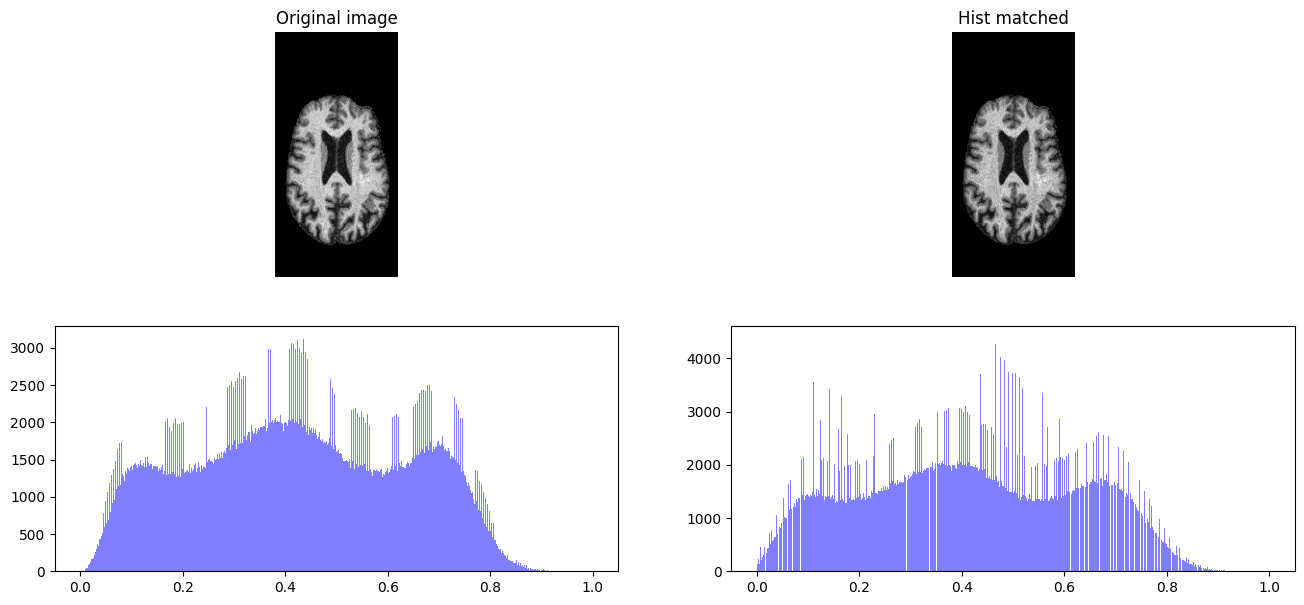

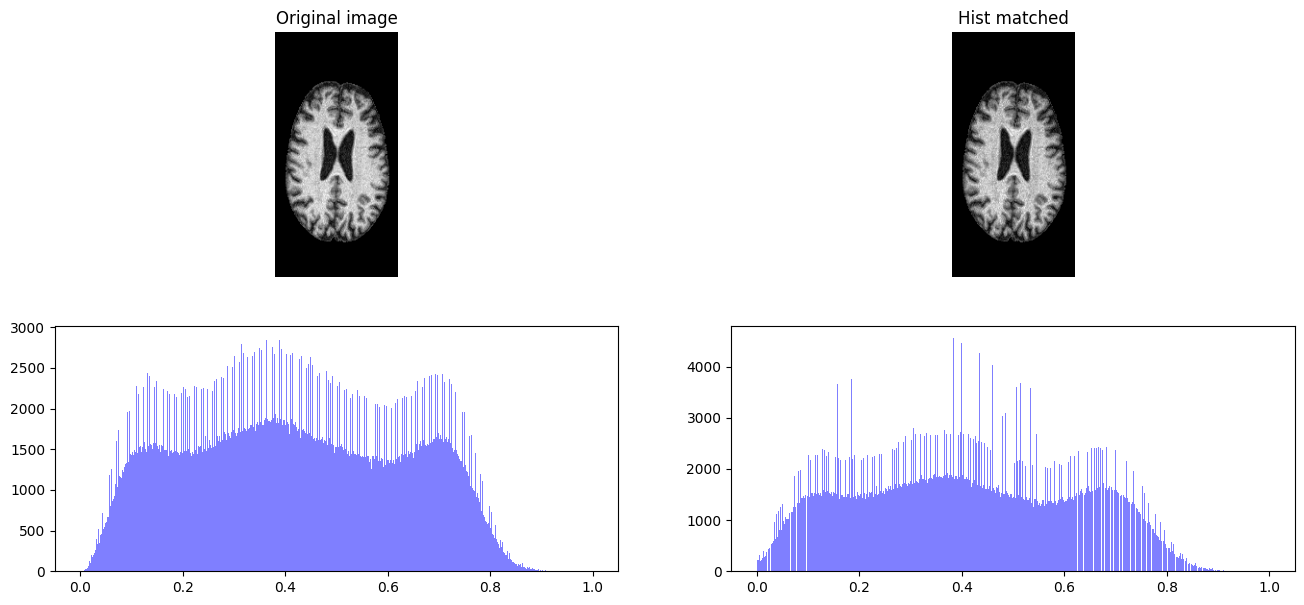

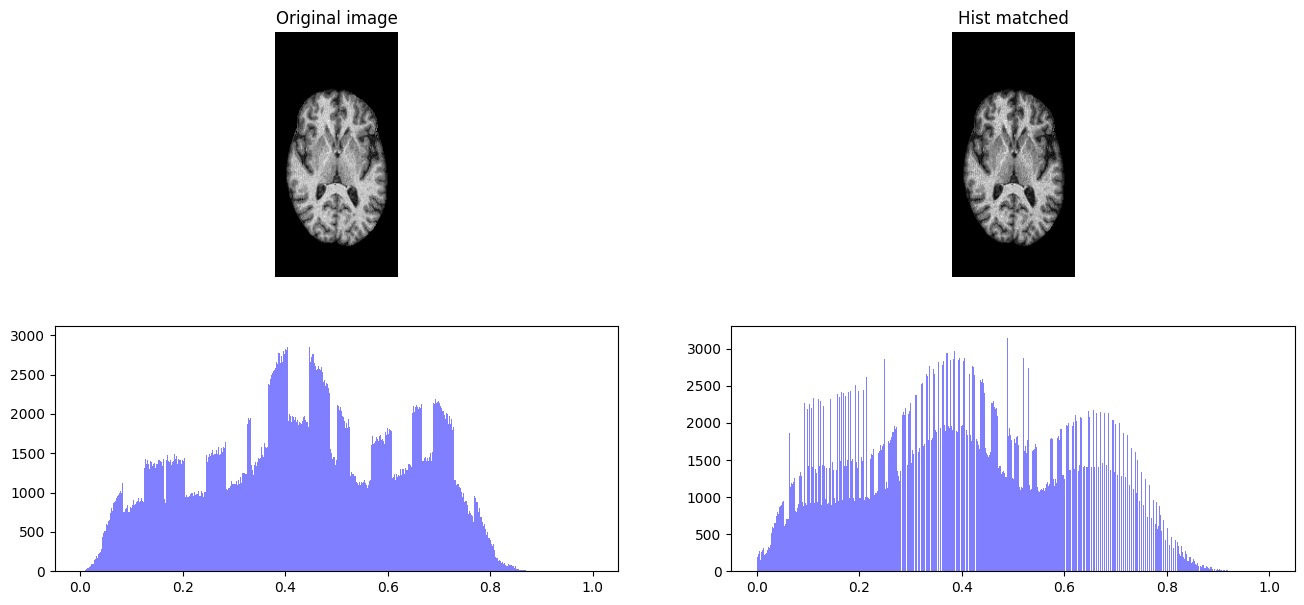

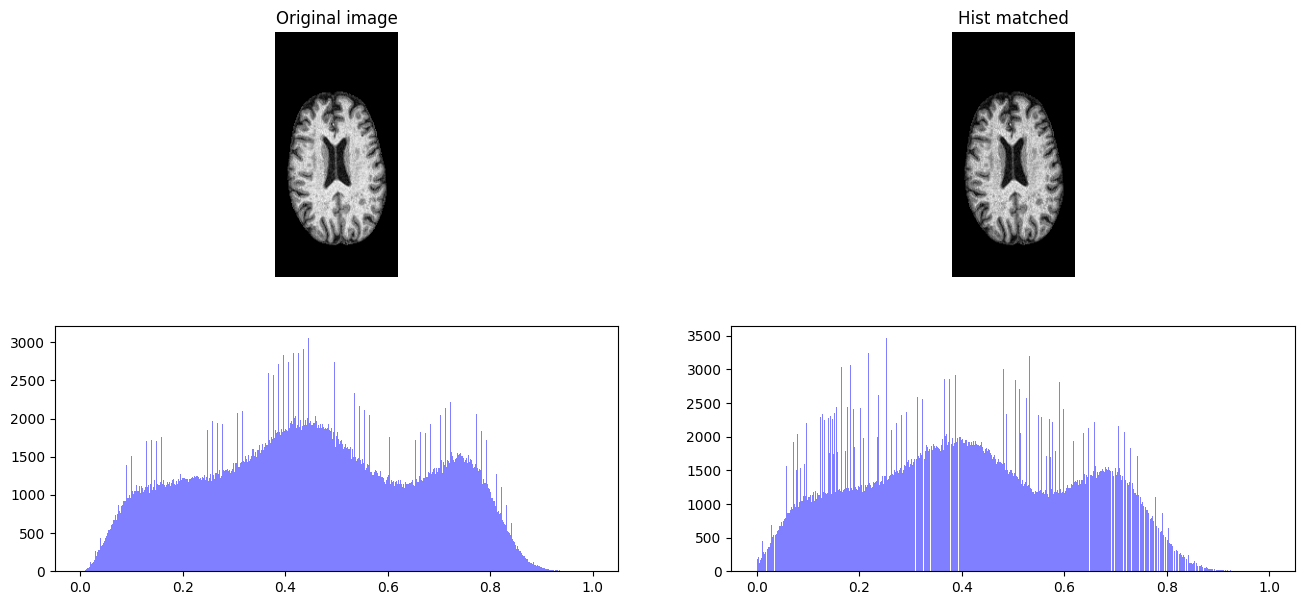

In [72]:
def perform_train_histogram_matching(save=False, visualize=True):
    for patient_id in pil.IMG_NUMBERS_TRAIN[:2]:
        # Looping through two time points for each image number
        for time in [1,2]:
            img, affine = pil.load_nsk_volume(patient_id, time, sub_folder=pil.FOLDER_RAW)
            mask, _ = pil.load_brain_mask(patient_id, time, sub_folder=pil.FOLDER_RAW)
            img = normalize_image(img, mask)
            img_hist_matched = _match_cumulative_cdf_hist(img, template_hist, template_bins, mask=mask)

            if save:
                pil.save_volume(img_hist_matched, affine, pil.NAME_HISTMATCHED, patient_id, longitudinal=time, sub_folder=pil.FOLDER_RAW)
            if visualize:
                _layer = get_best_layer(np.transpose(img, (0, 2, 1)))
                fig, axs = plt.subplots(2,2, figsize=(16, 7))

                fc.imgshow_matplotlib("Original image", np.flipud(np.transpose(img, (0, 2, 1))[..., _layer]), subplot=axs[0][0])
                fc.imgshow_matplotlib("Hist matched", np.flipud(np.transpose(img_hist_matched, (0, 2, 1))[..., _layer]), subplot=axs[0][1])

                img_hist, img_bins = np.histogram(img.ravel()[mask.ravel()>0], range=hist_range, bins=num_bins)
                matched_hist, matched_bins = np.histogram(img_hist_matched.ravel()[mask.ravel()>0], range=hist_range, bins=num_bins)
                fc.plot_precomputed_hist(img_hist, img_bins, title="", subplot=axs[1][0])
                fc.plot_precomputed_hist(matched_hist, matched_bins, title="", subplot=axs[1][1])

                plt.show()

perform_train_histogram_matching(save=False, visualize=True)

### Registration to the MNI space

In [11]:
registration_parameters_path = 'data/used_to_register/parameters'
affine_parameter_name = 'parameters_affine.txt'
no_rigid_parameter_name = 'parameters_no_rigid.txt'

mean_image_path_name = 'data/used_to_register/mni/mean_img.nii'
mask_mean_image_path_name = 'data/used_to_register/mni/icbm_avg_152_t1_tal_lin_mask.nii'

#### Skull stripping MNI mean image

In [12]:
# img, affine = nfc.load_nifti(mean_image_path_name)
# mask, _ = nfc.load_nifti(mask_mean_image_path_name)

# img_nsk = np.copy(img)
# img_nsk[mask==0] = 0

# nfc.save_nifit(img_nsk, affine, new_mean_image_path_name)


#### Registration functions

In [13]:
def get_affine_parameters():
    affine_parameters = os.path.join(registration_parameters_path, affine_parameter_name)
    affine_parameter_object = itk.ParameterObject.New()
    affine_parameter_object.AddParameterFile(affine_parameters)
    return affine_parameter_object

def get_no_rigid_parameters():
    no_rigid_parameters = os.path.join(registration_parameters_path, no_rigid_parameter_name)
    no_rigid_parameter_object = itk.ParameterObject.New()
    no_rigid_parameter_object.AddParameterFile(no_rigid_parameters)
    return no_rigid_parameter_object

def get_mean_img():
    mean_img = itk.imread(mean_image_path_name, itk.F)
    mask = itk.imread(mask_mean_image_path_name, itk.UC)
    return mean_img, mask

def register_img(moving, moving_mask):
    # load registration parameters
    affine_parameter_object = get_affine_parameters()
    no_rigid_parameter_object = get_no_rigid_parameters()
    fixed, fixed_mask = get_mean_img()

    print("Affine registration")
    moving_affine, affine_parameters_transformed = itk.elastix_registration_method(
                                                    fixed, moving,
                                                    parameter_object=affine_parameter_object,
                                                    fixed_mask=fixed_mask, moving_mask=moving_mask,
                                                    log_to_console=False)
    
    moving_mas_affine = itk.transformix_filter(moving_mask, affine_parameters_transformed)

    print("No rigid registration")
    moving_no_rigid, no_rigid_parameters_transformed = itk.elastix_registration_method(
                                                fixed, moving_affine,
                                                parameter_object=no_rigid_parameter_object,
                                                fixed_mask=fixed_mask, moving_mask=moving_mas_affine,
                                                log_to_console=False)

    return moving_no_rigid, affine_parameters_transformed, no_rigid_parameters_transformed


def register_img_and_labels(moving, moving_mask, labels):
    moving_no_rigid, affine_parameters_transformed, no_rigid_parameters_transformed = register_img(moving, moving_mask)
    registered_labels = []
    print("Transformix")

    for label in labels:
        label_affine = itk.transformix_filter(label, affine_parameters_transformed)
        label_no_rigid = itk.transformix_filter(label_affine, no_rigid_parameters_transformed)
        registered_labels.append(label_no_rigid)

    return moving_no_rigid, registered_labels

In [73]:
def perform_train_registration():
    for patient_id in pil.IMG_NUMBERS_TRAIN[:2]:
        print(f'-------- Registering patient {patient_id}')
        for time in [1,2]:
            print(f'---- Time {time}')

            # load images
            patient_path = pil.get_patient_path(patient_id, time, pil.FOLDER_RAW)

            volume_nsk_path_name = os.path.join(patient_path, pil.NAME_HISTMATCHED)
            img = itk.imread(volume_nsk_path_name, itk.F)

            mask_path_name = os.path.join(patient_path, pil.NAME_BRAIN_MASK)
            img_brain_mask = itk.imread(mask_path_name, itk.UC)

            labels_path_name = os.path.join(patient_path, pil.NAME_SPM_PROB_LABEL)
            img_gm_prob_label = itk.imread(labels_path_name.format(1), itk.F)
            img_wm_prob_label = itk.imread(labels_path_name.format(2), itk.F)
            img_csf_prob_label = itk.imread(labels_path_name.format(3), itk.F)

            # apply registration
            img_registered, labels_registered = register_img_and_labels(img, 
                                                                        img_brain_mask,
                                                                        [img_brain_mask,
                                                                         img_gm_prob_label,
                                                                         img_wm_prob_label,
                                                                         img_csf_prob_label])

            # sav registered images
            patient_registered_path = pil.get_patient_path(patient_id, time, pil.FOLDER_REGISTERED)
            
            # volume
            registered_volume_path_name = os.path.join(patient_registered_path, pil.NAME_NSK_VOLUME)
            itk.imwrite(img_registered, registered_volume_path_name)

            # mask
            registered_mask_path_name = os.path.join(patient_registered_path, pil.NAME_BRAIN_MASK)
            itk.imwrite(labels_registered[0], registered_mask_path_name)

            # gm
            registered_gm_path_name = os.path.join(patient_registered_path, pil.NAME_SPM_PROB_LABEL.format(1))
            itk.imwrite(labels_registered[1], registered_gm_path_name)

            # wm
            registered_wm_path_name = os.path.join(patient_registered_path, pil.NAME_SPM_PROB_LABEL.format(2))
            itk.imwrite(labels_registered[2], registered_wm_path_name)

            # csf
            registered_csf_path_name = os.path.join(patient_registered_path, pil.NAME_SPM_PROB_LABEL.format(3))
            itk.imwrite(labels_registered[3], registered_csf_path_name)

# perform_train_registration()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


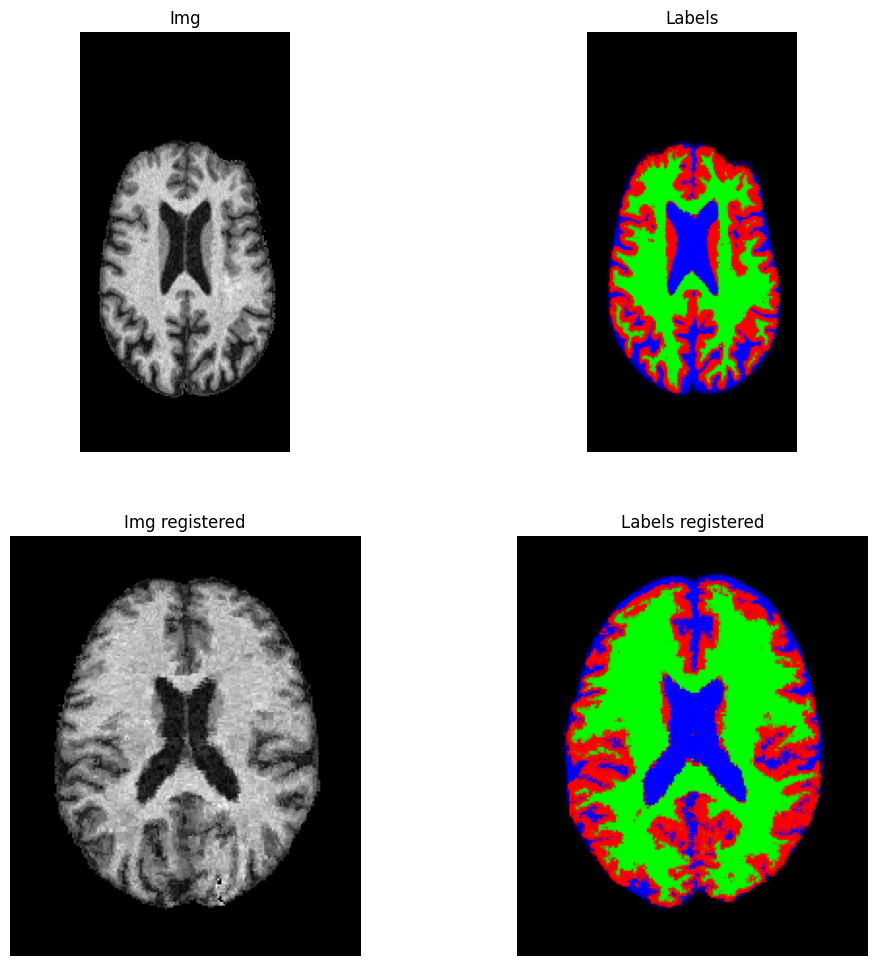

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


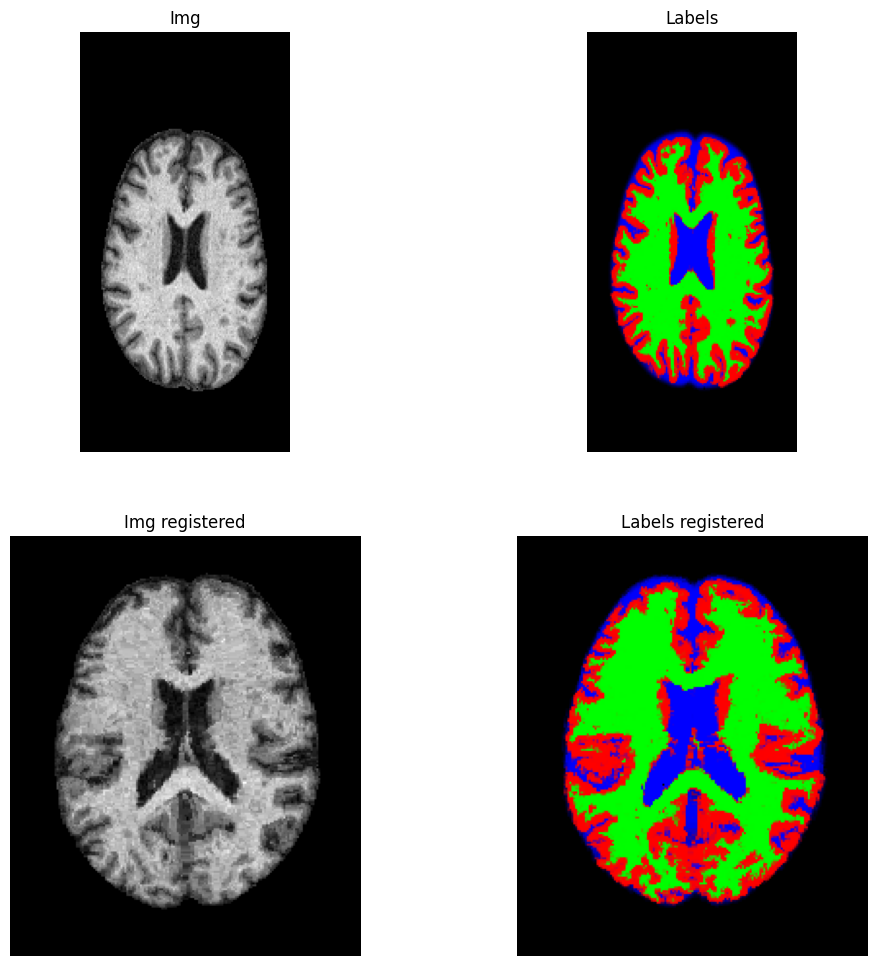

In [122]:
def visualize_registration():
    # perform with SPM software
    for patient_id in pil.IMG_NUMBERS_TRAIN[:2]:
        img_no_registered, _ = pil.load_nsk_volume(patient_id, 1, sub_folder=pil.FOLDER_RAW)
        img_registered, _ = pil.load_nsk_volume(patient_id, 1, sub_folder=pil.FOLDER_REGISTERED, transpose=True)

        img_gm_prob_label1, img_wm_prob_label1, img_csf_prob_label1 = pil.load_spm_labels(patient_id, 1, pil.FOLDER_RAW, -1)
        img_gm_prob_label2, img_wm_prob_label2, img_csf_prob_label2 = pil.load_spm_labels(patient_id, 2, pil.FOLDER_REGISTERED, -1, transpose=True)

        fig, axs = plt.subplots(2,2, figsize=(12, 12))
        _layer1 = 150
        _layer2 = 90

        color_atlas_1 = prob_color_atlas([np.transpose(img_gm_prob_label1, (0, 2, 1)), np.transpose(img_wm_prob_label1, (0, 2, 1)), np.transpose(img_csf_prob_label1, (0, 2, 1))], _layer1)
        color_atlas_2 = prob_color_atlas([img_gm_prob_label2, img_wm_prob_label2, img_csf_prob_label2], _layer2)

        fc.imgshow_matplotlib("Img",  np.flipud(np.transpose(img_no_registered, (0, 2, 1))[..., _layer1]), subplot=axs[0][0])
        fc.imgshow_matplotlib("Labels",  np.flipud(color_atlas_1), subplot=axs[0][1])
        fc.imgshow_matplotlib("Img registered",  np.flipud(img_registered[..., _layer2]), subplot=axs[1][0])
        fc.imgshow_matplotlib("Labels registered",  np.flipud(color_atlas_2), subplot=axs[1][1])
        plt.show()

visualize_registration()